In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


## Data

In [2]:
data_dir = '/home/nikhil/projects/SDC-BIDS-sMRI/local_data/AOMIC/'

participant_csv = data_dir + 'participants.tsv'

participant_data = pd.read_csv(participant_csv, sep='\t')
participant_data.head()

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53


### Cortical thickness

In [3]:
parcels = 'DKT' # 'DKT' or 'Destrieux'

CT_df = pd.DataFrame() #Combines data from from left and right hemispheres

for hemi in ['lh','rh']:
    if parcels == 'DKT':
        parcels_csv = data_dir + 'derivatives/fs_stats/data-cortical_type-aparc_measure-thickness_hemi-{}.tsv'.format(hemi)
        CT_data = pd.read_csv(parcels_csv,sep='\t')

        # rename columns to cocat multiple cohorts / hemis
        orig_columns = list(CT_data.columns)
        
        # rename freesurfer columns to remove verbose suffixes
        renamed_columns = ['participant_id'] + [c.split('_')[1] for c in orig_columns[1:-2]]
    else:
        parcels_csv = data_dir + 'derivatives/fs_stats/data-cortical_type-aparc.a2009s_measure-thickness_hemi-{}.tsv'.format(hemi)

        CT_data = pd.read_csv(parcels_csv,sep='\t')

        # rename columns to cocat multiple cohorts / hemis
        orig_columns = list(CT_data.columns)
        
        # rename freesurfer columns to remove verbose suffixes
        renamed_columns = ['participant_id'] + [c.split('_',1)[1].rsplit('_',1)[0].replace('&', '_and_').replace('-', '_') for c in orig_columns[1:-2]]

    # Subset of ROI columns
    roi_columns = renamed_columns[1:-1]

    print('Parcellation: {}, hemisphere: {}, Number of ROIs: {}'.format(parcels, hemi, len(roi_columns)))

    CT_data = CT_data.rename(columns=dict(zip(orig_columns,renamed_columns)))
    CT_data['hemi'] = hemi

    CT_df = CT_df.append(CT_data)

CT_df.head()

Parcellation: DKT, hemisphere: lh, Number of ROIs: 34
Parcellation: DKT, hemisphere: rh, Number of ROIs: 34


,participant_id,bankssts,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,isthmuscingulate,...,superiortemporal,supramarginal,frontalpole,temporalpole,transversetemporal,insula,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,2.451,2.804,2.655,2.090,3.817,2.764,2.493,2.768,2.474,...,2.756,2.659,2.856,3.336,2.741,3.442,2.56319,1235952.0,1.560839e+06,lh
1,sub-0002,2.112,2.885,2.441,2.015,3.036,2.645,2.499,2.534,2.778,...,2.734,2.589,2.727,3.043,2.630,3.070,2.45906,1056970.0,1.115228e+06,lh
2,sub-0003,2.649,3.252,2.400,2.006,3.487,2.760,2.496,2.701,2.848,...,2.783,2.674,2.855,3.738,2.517,3.064,2.53882,945765.0,1.186697e+06,lh
3,sub-0004,2.616,2.810,2.602,1.860,3.436,2.781,2.601,2.664,2.387,...,2.748,2.602,2.899,3.545,2.659,2.930,2.51095,973916.0,9.527770e+05,lh
4,sub-0005,2.765,3.663,2.556,1.872,3.955,2.714,2.510,2.724,2.556,...,2.885,2.658,2.587,3.782,2.648,3.324,2.53809,1089881.0,1.497743e+06,lh


## Merge demographics and CT

In [4]:
demograph_columns = ['participant_id',	'age', 'sex', 'BMI', 'handedness', 'education_category']

Analysis_data = pd.merge(participant_data[demograph_columns], CT_df, on='participant_id')

print('Shape of Analysis dataframe {}'.format(Analysis_data.shape))

Analysis_data.head()

Shape of Analysis dataframe (452, 44)


,participant_id,age,sex,BMI,handedness,education_category,bankssts,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,...,superiortemporal,supramarginal,frontalpole,temporalpole,transversetemporal,insula,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,25.50,M,21.0,right,academic,2.451,2.804,2.655,2.090,...,2.756,2.659,2.856,3.336,2.741,3.442,2.56319,1235952.0,1.560839e+06,lh
1,sub-0001,25.50,M,21.0,right,academic,2.435,2.711,2.513,2.062,...,2.789,2.594,2.439,3.972,2.489,3.454,2.51401,1235952.0,1.560839e+06,rh
2,sub-0002,23.25,F,22.0,right,academic,2.112,2.885,2.441,2.015,...,2.734,2.589,2.727,3.043,2.630,3.070,2.45906,1056970.0,1.115228e+06,lh
3,sub-0002,23.25,F,22.0,right,academic,2.367,2.771,2.451,1.931,...,2.739,2.447,2.621,3.508,2.676,3.196,2.48084,1056970.0,1.115228e+06,rh
4,sub-0003,25.00,F,23.0,right,applied,2.649,3.252,2.400,2.006,...,2.783,2.674,2.855,3.738,2.517,3.064,2.53882,945765.0,1.186697e+06,lh


## Visualize distributions

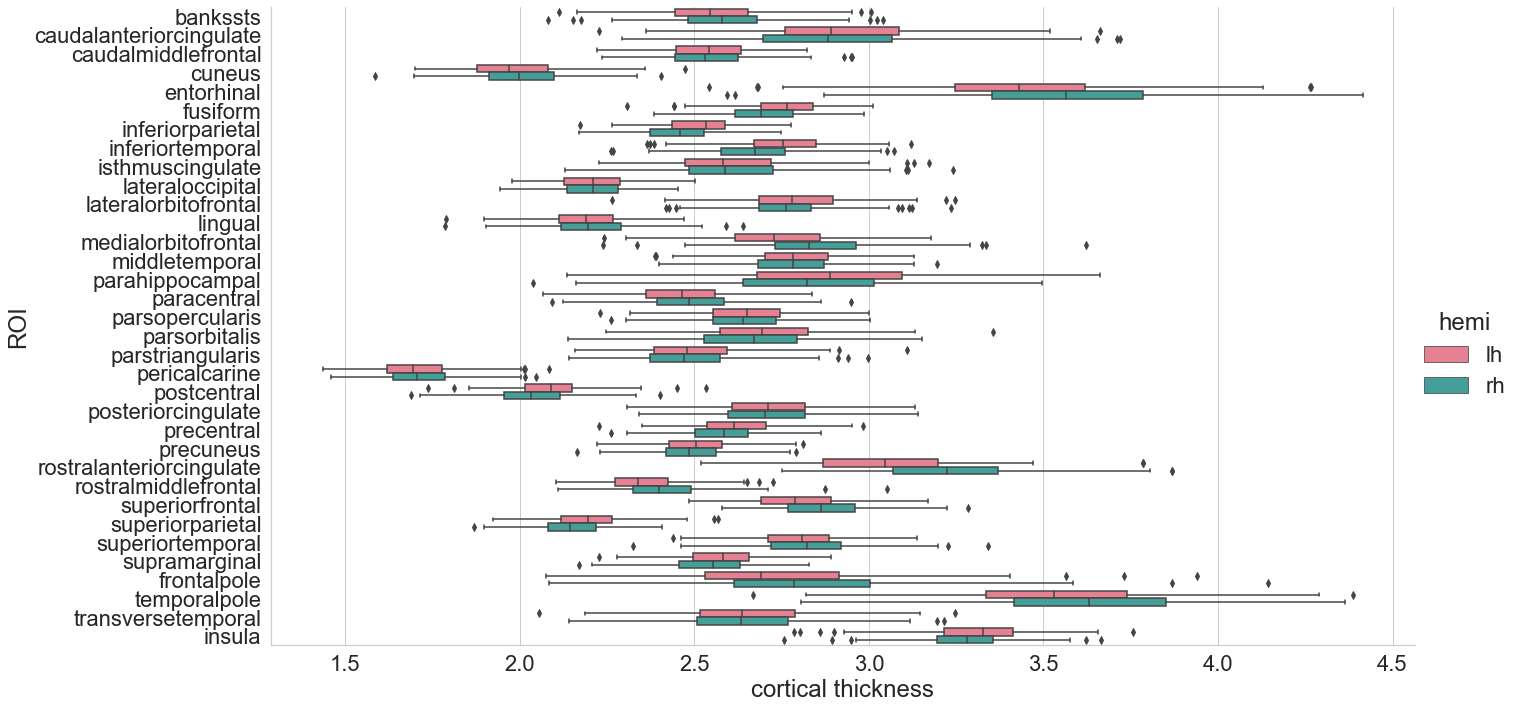

In [5]:
plot_df = Analysis_data[demograph_columns + ['hemi'] + roi_columns].copy()

id_vars = demograph_columns + ['hemi'] 
value_vars = roi_columns

## Melt dataframe for easier visualization
plot_df = pd.melt(plot_df, id_vars = id_vars, value_vars = value_vars, 
                      var_name ='ROI', value_name ='cortical thickness')
sns.set(font_scale=2)
palette = sns.color_palette('husl',2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', aspect=2, height=10, palette = palette, data=plot_df)

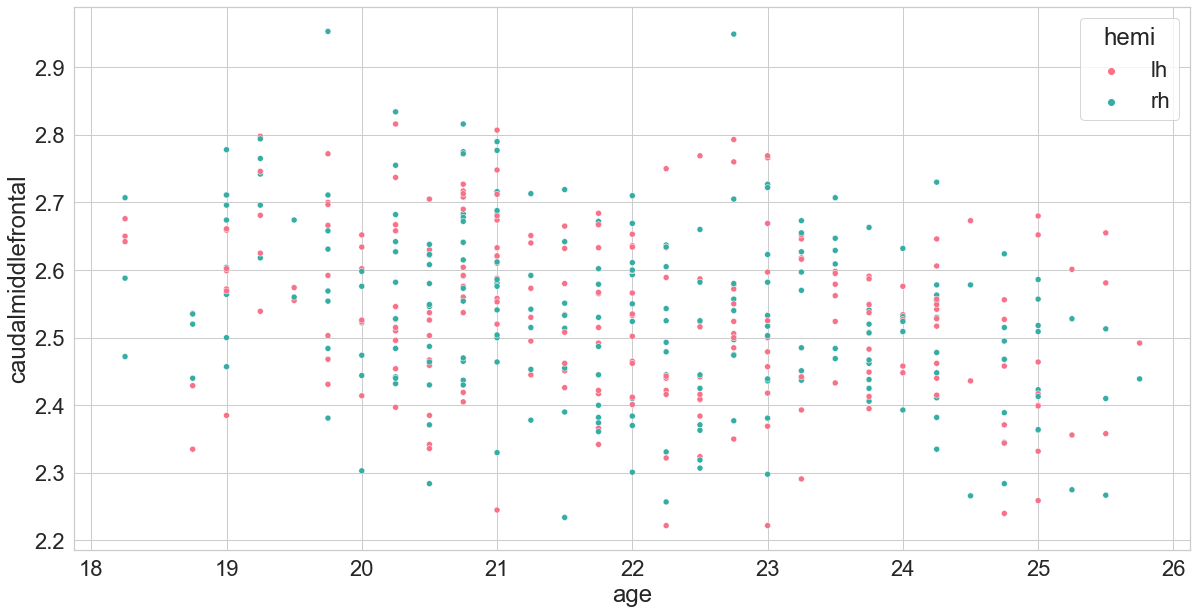

In [14]:
plot_df = Analysis_data.copy()

dependent_var = 'caudalmiddlefrontal' #'eTIV' #'entorhinal', #'caudalmiddlefrontal'
independent_var = 'age'

sns.set(font_scale=2)
palette = sns.color_palette('husl',2)
with sns.axes_style("whitegrid"):
    f, axes = plt.subplots(1,figsize=(20, 10))
    g = sns.scatterplot(x=independent_var, y=dependent_var, hue='hemi', palette=palette, data=plot_df)

## Statsmodels

### OLS: Single ROI

In [16]:
dependent_var = 'caudalmiddlefrontal' #'entorhinal'
independent_var = 'age'
hemi = 'lh'

stat_df = Analysis_data[Analysis_data['hemi']==hemi].copy()

covar_str = 'eTIV + C(sex)' # [age, sex, BMI, education_category]

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('{} ~ {} + {}'.format(dependent_var, independent_var, covar_str), data=stat_df).fit()

# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     caudalmiddlefrontal   R-squared:                       0.134
Model:                             OLS   Adj. R-squared:                  0.122
Method:                  Least Squares   F-statistic:                     11.30
Date:                 Sat, 29 May 2021   Prob (F-statistic):           6.35e-07
Time:                         16:49:09   Log-Likelihood:                 169.58
No. Observations:                  224   AIC:                            -331.2
Df Residuals:                      220   BIC:                            -317.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7708      0.114     24.412      0.000       2.547       2.994
C(sex)[T.M]    -0.0153      0.020     -0.751      0.453      -0.055       0.025
age            -0.0194      0.004     -4.505      0.000      -0.028      -0.011
eTIV         1.495e-07    4.7e-08      3.179      0.002    5.68e-08    2.42e-07
==============================================================================
Omnibus:                        2.557   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.203
Skew:                          -0.135   Prob(JB):                        0.332
Kurtosis:                       2.596   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## OLS
### Exploratory: check all ROIs

In [8]:
def format_ols_results(res):
    ''' Converts statsmodels summary results (table2) into dataframe with minimum usuful stat results'''

    results_summary = res.summary()
    results_as_html = results_summary.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()
    res_df['R2'] = res.rsquared
    res_df['R2_adj'] = res.rsquared_adj

    return res_df

In [25]:
# OLS result df
ols_df = pd.DataFrame()

independent_var = 'age'
covar_str = 'eTIV + C(sex)'

for hemi in ['lh','rh']:
    stat_df = Analysis_data[Analysis_data['hemi']==hemi].copy()

    for dependent_var in roi_columns:
        res = smf.ols(formula='{} ~ {} + {}'.format(dependent_var, covar_str, independent_var), data=stat_df).fit()
        res_df = format_ols_results(res)
        res_df['dependent_var'] = dependent_var
        res_df['hemi'] = hemi
        ols_df = ols_df.append(res_df)

ols_df.head()

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var,hemi
0,Intercept,2.758900e+00,1.550000e-01,17.819,0.000,2.454000e+00,3.064000e+00,0.024687,0.011387,bankssts,lh
1,C(sex)[T.M],-8.500000e-03,2.800000e-02,-0.306,0.760,-6.300000e-02,4.600000e-02,0.024687,0.011387,bankssts,lh
2,eTIV,5.365000e-08,6.420000e-08,0.836,0.404,-7.280000e-08,1.800000e-07,0.024687,0.011387,bankssts,lh
3,age,-1.260000e-02,6.000000e-03,-2.152,0.033,-2.400000e-02,-1.000000e-03,0.024687,0.011387,bankssts,lh
0,Intercept,3.384000e+00,2.490000e-01,13.572,0.000,2.893000e+00,3.875000e+00,0.029619,0.016386,caudalanteriorcingulate,lh


Using corrected p-val threshold of 0.0007
signficant ROIs: [('caudalmiddlefrontal', 'lh'), ('inferiorparietal', 'lh'), ('middletemporal', 'lh'), ('paracentral', 'lh'), ('parsopercularis', 'lh'), ('precuneus', 'lh'), ('superiorfrontal', 'lh'), ('superiortemporal', 'lh'), ('transversetemporal', 'lh'), ('caudalmiddlefrontal', 'rh'), ('cuneus', 'rh'), ('fusiform', 'rh'), ('middletemporal', 'rh'), ('paracentral', 'rh'), ('precentral', 'rh'), ('precuneus', 'rh'), ('superiorfrontal', 'rh'), ('transversetemporal', 'rh')]


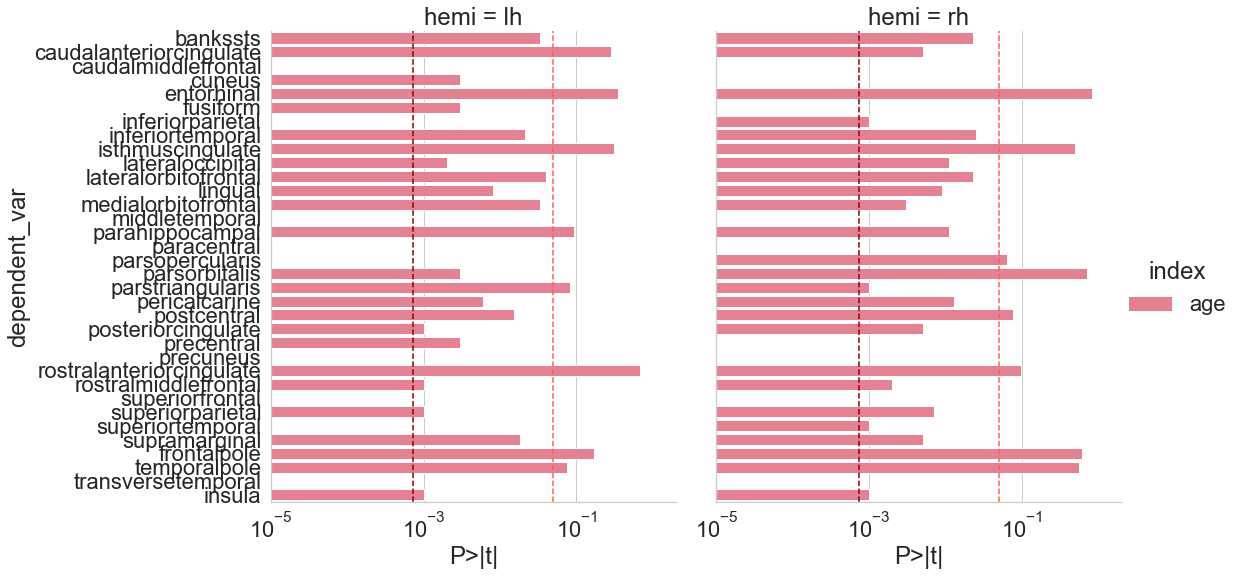

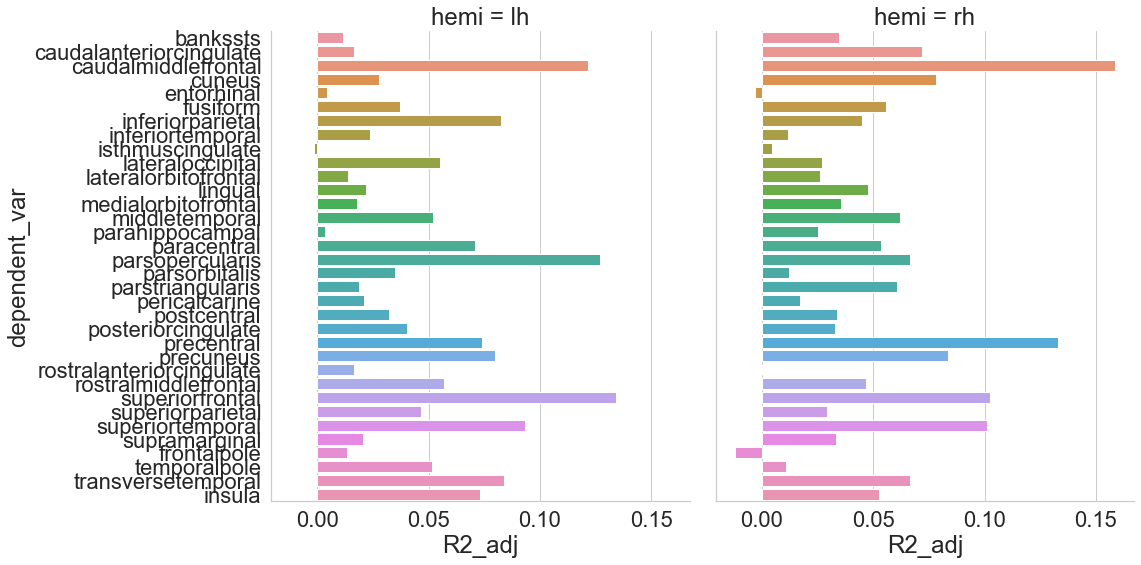

In [27]:
compare_levels = ['age']

plot_df = ols_df[ols_df['index'].isin(compare_levels)].copy()
n_compare = 2*len(roi_columns) 
signific_thesh = 0.05/(n_compare)
print('Using corrected p-val threshold of {:5.4f}'.format(signific_thesh))

signific_ROIs = plot_df[plot_df['P>|t|'] < signific_thesh]['dependent_var'].values
signific_hemis = plot_df[plot_df['P>|t|'] < signific_thesh]['hemi'].values

print('signficant ROIs: {}'.format(list(zip(signific_ROIs,signific_hemis))))

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='P>|t|', y='dependent_var', kind='bar', hue='index', col='hemi', aspect=1, height=8, palette=palette,
                    data=plot_df)
    g.set(xscale='log',xlim=(1e-5,2))
    for ax in g.axes.flat:
        ax.axvline(0.05, ls='--',c='tomato')
        ax.axvline(signific_thesh, ls='--',c='darkred')

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='R2_adj', y='dependent_var', col='hemi', kind='bar', aspect=1, height=8,
                    data=plot_df)